#Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
import warnings
warnings.simplefilter("ignore")

#Data

(V, Q, Q_r, S_i, dS, TS_i, dTS, N_i, dN, M, DO, i, Sig/TS, Sig, TKN, X, Th, Th_c, Th_n, Th_cn)

In [ ]:
df = pd.read_csv('/content/ASP_Data.csv')
df.head(1)

,V,Si,So,TSi,TSo,Ni,No,TKNi,TKNo,M,...,Sig,Q,Th_c,Th,dS,dTS,dN,TKN,Thn,Th_cn
0,3132,261,44,309,19,49,11,87,22,2634,...,192,1746.83,9.69,9.17,217,290,38,65,2.2925,11.217412


In [ ]:
psi_1 = 0.8
psi_2 = 0.2

In [ ]:
df['X'] = df['M']*df['Sig/TS']

#C-BOD Removal Regression 1

In [ ]:
df1 = pd.DataFrame()

df1['y'] = df['V']*df['Sig']*df['M']/(2*df['Q']*df['dS']*df['dTS'])
df1['x1'] = df['X']/df['Si']
df1['x2'] = df['Th']/2

df1.head(3)

,y,x1,x2
0,7.204443,6.257011,4.585
1,9.597418,7.344955,4.605
2,9.411484,7.371014,4.580


In [ ]:
y1 = df1['y']
x1 = df1.drop(['y'], axis = 1)

x11 = df1['x1']
x12 = df1['x2']

In [ ]:
df1.corr()

,y,x1,x2
y,1.000000,0.908274,0.029829
x1,0.908274,1.000000,-0.016602
x2,0.029829,-0.016602,1.000000


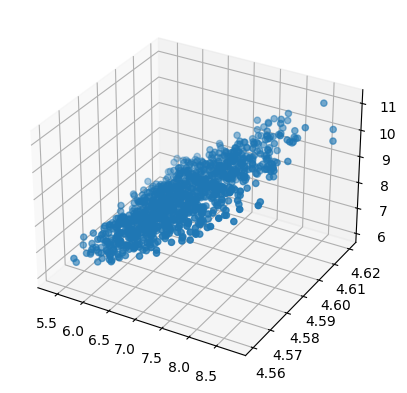

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(df1['x1'], df1['x2'], df1['y'])
plt.show()

In [ ]:
def func1(vars, alpha, beta, gamma):
  x11, x12 = vars
  return alpha*x11/(1 - np.exp(beta*x12)) + gamma

In [ ]:
ind_vars = np.vstack((x11, x12))
popt1, pcov1 = curve_fit(func1, ind_vars, y1)

alpha = popt1[0]
beta = popt1[1]
gamma = popt1[2]

###Equation

In [ ]:
print(f'y = ({alpha:.2e}).x1/(1 - e^({beta:.2e}).x2) + ({gamma:.2e})')

y = (-3.66e-04).x1/(1 - e^(6.58e-05).x2) + (-2.27e-02)


In [ ]:
r21 = r2_score(y1, func1(ind_vars, alpha, beta, gamma))
print(f'R2 = {r21:.3f}')

R2 = 0.821


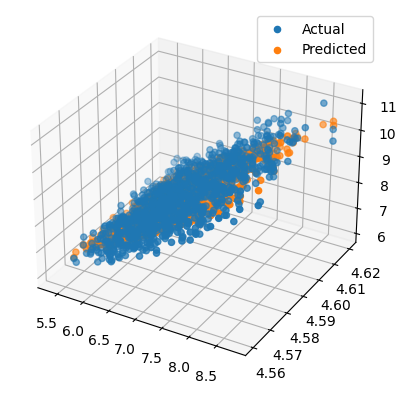

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(df1['x1'], df1['x2'], df1['y'], label = "Actual")
axes.scatter(df1['x1'], df1['x2'], func1(ind_vars, alpha, beta, gamma), label = "Predicted")
plt.legend()
plt.show()

###Constants

In [ ]:
Kd = -beta
print(f'Kd = {Kd:.2e}')

Kd = -6.58e-05


In [ ]:
k = 1/(psi_1*gamma)
print(f'k = {k:.3f}')

k = -55.024


In [ ]:
Ks = alpha/gamma
print(f'Ks = {Ks:.4f}')

Ks = 0.0161


#C-BOD Removal Regression 2

In [ ]:
df2 = pd.DataFrame()

c = Ks/(psi_1*Kd)
df2['y'] = (2*c/(df['Si']*df['Th']) + 1)/(df['X'])
df2['x'] = df['Th_c']

df2.head(3)

,y,x
0,0.000615,9.69
1,0.000622,10.50
2,0.000659,13.41


In [ ]:
y2 = df2['y']
x2 = df2.drop(['y'], axis = 1)

In [ ]:
df2.corr()

,y,x
y,1.000000,-0.163795
x,-0.163795,1.000000


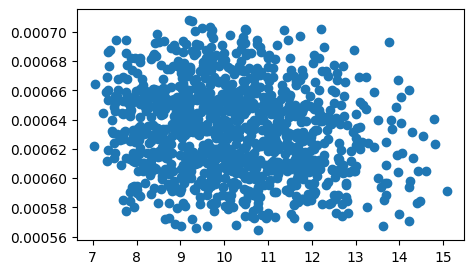

In [ ]:
plt.figure(figsize = (5, 3))
plt.scatter(x2, y2)
plt.show()

In [ ]:
x2 = x2.values.reshape(-1, 1)
poly2 = PolynomialFeatures(degree = 2, include_bias = False)
x2_poly = poly2.fit_transform(x2)

In [ ]:
LR2 = LinearRegression(fit_intercept = False)
LR2.fit(x2_poly, y2)

LinearRegression(fit_intercept=False)

###Equation

In [ ]:
coeff = LR2.coef_
itcept = LR2.intercept_

c1 = coeff[1]
c2 = coeff[0]
c3 = -1

print(f'y = ({c1:.2e}).x^2 + ({c2:.2e}).x + ({c3:.3f})')

y = (-5.95e-06).x^2 + (1.24e-04).x + (-1.000)


In [ ]:
r22 = r2_score(y2, LR2.predict(x2_poly))
r22

-0.3044007123080015

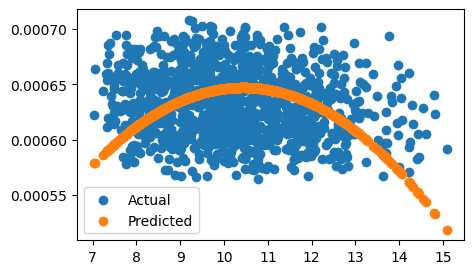

In [ ]:
plt.figure(figsize = (5, 3))
plt.scatter(x2, y2, label = "Actual")
plt.scatter(x2, LR2.predict(x2_poly), label = "Predicted")
plt.legend()
plt.show()

###Constants

In [ ]:
Mu_max = c2
print(f'Mu_max = {Mu_max:.3f}')

Mu_max = 0.000


In [ ]:
Kd = -c1/c2
print(f'Kd = {Kd:.4f}')

Kd = 0.0479


In [ ]:
Y = Mu_max/k

###Psi_1 Calc

In [ ]:
df['psi_1'] = 2*np.sqrt(np.abs(Ks*df['Q']/(Kd*df['Si']*df['V']*(1 - Mu_max*df['X']*df['Th_c']*(1 - Kd*df['Th_c'])))))

df['psi_1'] = df['psi_1'].clip(lower = 0, upper = 1)
df.head(3)

,V,Si,So,TSi,TSo,Ni,No,TKNi,TKNo,M,...,Th,dS,dTS,dN,TKN,Thn,Th_cn,X,psi_1,psi_2
0,3132,261,44,309,19,49,11,87,22,2634,...,9.17,217,290,38,65,2.2925,11.217412,1633.08,0.236251,0.843656
1,3105,220,37,271,22,44,11,88,23,2649,...,9.21,183,249,33,65,2.3025,12.948892,1615.89,0.259378,0.646014
2,2916,207,33,235,21,42,10,79,20,2543,...,9.16,174,214,32,59,2.2900,16.777261,1525.80,0.188347,0.823240


#NH4-N Removal Regression 1

In [ ]:
df3 = pd.DataFrame()

df3['y'] = df['V']*df['M']/(2*df['Q']*df['dN']*df['dTS'])
df3['x1'] = 2*df['Q']*df['X']/(df['Ni']*df['V'])
df3['x2'] = 1/df['Sig']
df3['x3'] = 1/df['DO']

df3.head(3)

,y,x1,x2,x3
0,0.214277,37.176651,0.005208,0.393701
1,0.320615,36.927025,0.006024,0.492611
2,0.365535,36.906390,0.007143,0.487805


In [ ]:
y3 = df3['y']
x3 = df3.drop(['y'], axis = 1)

In [ ]:
df3.corr()

,y,x1,x2,x3
y,1.000000,0.724766,0.818506,0.665093
x1,0.724766,1.000000,0.472028,0.493988
x2,0.818506,0.472028,1.000000,0.700760
x3,0.665093,0.493988,0.700760,1.000000


In [ ]:
def func3(vars, c31, c32, c33, c34):
  x1, x2, x3 = vars
  return x1*c34*(c31*x2 + c32)*(c33*x3 - 1)

In [ ]:
ind_vars3 = np.vstack((df3['x1'], df3['x2'], df3['x3']))
popt3, pcov3 = curve_fit(func3, ind_vars3, df3['y'])

c31 = popt3[0]
c32 = popt3[1]
c33 = popt3[2]
c34 = popt3[3]

###Equation

In [ ]:
print(f'y = ({c31:.3f}) + ({c32:.2e}).x1 + ({c33:.2e}).x2 + ({c34:.2e}).x3')

y = (80.181) + (-3.56e-02).x1 + (6.86e-02).x2 + (-1.72e-02).x3


In [ ]:
r23 = r2_score(y3, func3(ind_vars3, *popt3))
r23

0.7952242220894176

###Constants

In [ ]:
kn = 1/c32
print(f'kn = {kn:.3f}')

kn = -28.128


In [ ]:
Ko = c33
print(f'Ko = {Ko:.2e}')

Ko = 6.86e-02


In [ ]:
# c31 = Kn/(kn*psi_2*Kdn)
# c34 = 1/psi_2
# c32 = 1/kn
# c33 = Ko

#NH4-N Removal Regression 2

In [ ]:
df4 = pd.DataFrame()

# df4['y'] = (1/df['Th']) + df['Ni']/(2*b1*df['X'])
# df4['x1'] = (df['Ni']*(df['Th_cn']**2)/(2*b1*df['X'])) + (b2*df['Ni']*(df['Th_cn']**2)/(2*b1*df['X']*df['DO']))
# df4['x2'] = (df['Ni']*(df['Th_cn'])/(2*b1*df['X'])) + (b2*df['Ni']*(df['Th_cn'])/(2*b1*df['X']*df['DO']))

d4 = c31/(c32*c34)

# Kn = d4*Kdn

df4['y'] =

df4.head(3)

,y,x1,x2
0,0.884662,112.942364,10.068487
1,0.812454,141.243209,10.907744
2,0.820723,239.308468,14.263858


In [ ]:
y4 = df4['y']
x4 = df4.drop(['y'], axis = 1)

In [ ]:
df4.corr()

,y,x1,x2
y,1.000000,0.104372,0.373912
x1,0.104372,1.000000,0.955257
x2,0.373912,0.955257,1.000000


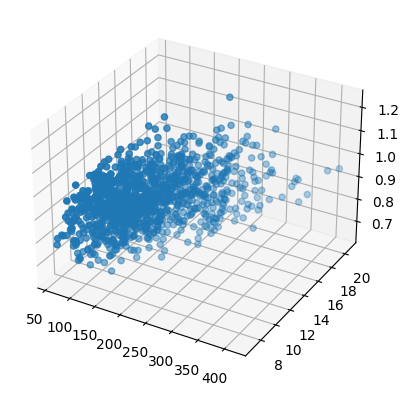

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(df4['x1'], df4['x2'], df4['y'])
plt.show()

In [ ]:
LR4 = LinearRegression(fit_intercept = False)
LR4.fit(x4, y4)

LinearRegression(fit_intercept=False)

###Equation

In [ ]:
coeff = LR4.coef_

b11 = coeff[0]
b21 = coeff[1]

print(f'y = ({b11:.2e}).x1 + ({b21:.2e}).x2')

y = (-5.34e-03).x1 + (1.45e-01).x2


In [ ]:
r24 = r2_score(y4, LR4.predict(x4))
r24

0.8327064951835579

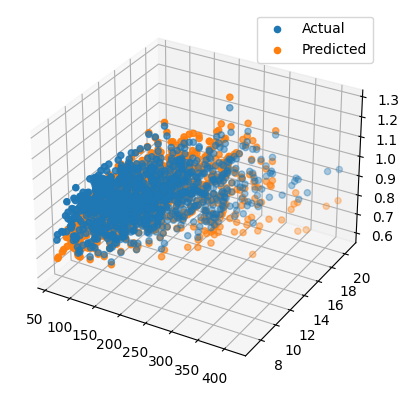

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
axes.scatter(df4['x1'], df4['x2'], df4['y'], label = "Actual")
axes.scatter(df4['x1'], df4['x2'], LR4.predict(x4), label = "Predicted")
axes.legend()
plt.show()

###Constants

In [ ]:
Mu_nm = -b21
print(f'Mu_nm = {Mu_nm:.2f}')

Mu_nm = -0.14


In [ ]:
Kdn = -b11/b21
print(f'Kdn = {Kdn:.3f}')

Kdn = 0.037


In [ ]:
Yn = Mu_nm/kn
print(f'Yn = {Yn:.3f}')

Yn = -3.864


In [ ]:
Kn = Kdn*psi_2*b1
print(f'Kn = {Kn:.2e}')

Kn = 1.43e-04


###Psi_2 Calc

In [ ]:
df['psi_2'] = np.sqrt(Kn*df['Q']*df['X']/(df['Ni']*df['V']*Kdn*(Mu_nm*(Ko/df['DO'] + 1)*df['Th_cn']*(Kdn*df['Th_cn'] - 1) - 1)))

df.head(3)

,V,Si,So,TSi,TSo,Ni,No,TKNi,TKNo,M,...,Th,dS,dTS,dN,TKN,Thn,Th_cn,X,psi_1,psi_2
0,3132,261,44,309,19,49,11,87,22,2634,...,9.17,217,290,38,65,2.2925,11.217412,1633.08,0.084542,0.843656
1,3105,220,37,271,22,44,11,88,23,2649,...,9.21,183,249,33,65,2.3025,12.948892,1615.89,0.085402,0.646014
2,2916,207,33,235,21,42,10,79,20,2543,...,9.16,174,214,32,59,2.2900,16.777261,1525.80,0.083117,0.823240


#Results

####Psi_1

In [ ]:
psi_1 = df['psi_1'].mean()
psi_1_min = df['psi_1'].min()
psi_1_max = df['psi_1'].max()

print(f'psi_1 :\n Range       : ({psi_1_min:.3f}, {psi_1_max:.3f})')
print(f' Mean Value  : {psi_1:.4f}')

psi_1 :
 Range       : (0.134, 1.000)
 Mean Value  : 0.3579


####Psi_2

In [ ]:
psi_2 = df['psi_2'].mean()
psi_2_min = df['psi_2'].min()
psi_2_max = df['psi_2'].max()

print(f'psi_2 :\n Range       : ({psi_2_min:.3f}, {psi_2_max:.3f})')
print(f' Mean Value  : {psi_2:.4f}')

psi_2 :
 Range       : (0.553, 4.152)
 Mean Value  : 0.7503


####Constants

In [ ]:
print(f'Mu_max = {Mu_max:.1f}')
print(f'Mu_nm = {Mu_nm:.2f}\n')
print(f'Kd = {Kd:.3f}')
print(f'Kdn = {Kdn:.3f}\n')
print(f'Ks = {Ks:.3f}')
print(f'Kn = {Kn:.4f}')

Mu_max = -70.2
Mu_nm = -0.14

Kd = 0.035
Kdn = 0.037

Ks = 0.016
Kn = 0.0001
